In [56]:
import pandas as pd
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
from contextlib import contextmanager
from functools import wraps, partial


import os

from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
from sklearn.utils import shuffle

import imageio
from yellowbrick.text import TSNEVisualizer
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from collections import Counter

In [2]:
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609]
Version info.
sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


In [3]:
import pickle
def save(mapping_dict, name):
    with open('data/{}.pickle'.format(name), 'wb') as handle:
        pickle.dump(mapping_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load(name):
    with open('data/{}.pickle'.format(name), 'rb') as handle:
        return pickle.load(handle)
    

def save_result(file_name=None, calculate=False, skip=False):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            
            final_file_name = kwargs['file_name'] if 'file_name' in kwargs else file_name
            
            if calculate:
                result = func(*args, **kwargs)
                if final_file_name:
                    if isinstance(result, pd.DataFrame):
                        result.to_parquet('data/{}.parquet'.format(final_file_name))
                    elif isinstance(result, matplotlib.figure.Figure):
                        result.savefig('img/{}.png'.format(result._suptitle._text), dpi=100)
                        save(result, result._suptitle._text)
                        return
                    else:
                        save(result, final_file_name)
                return result
            else:
                if not skip and 'title' in kwargs:
                    display('read {}'.format(kwargs['title']))
                    return load(kwargs['title'])                    
                if not skip and final_file_name:
                    display('read {}'.format(final_file_name))
                    if os.path.isfile('data/{}.parquet'.format(final_file_name)) :
                        return pd.read_parquet('data/{}.parquet'.format(final_file_name))
                    else:
                        return load(final_file_name)                    
                else:
                    display('code skipped')
                    return
        return wrapper

    return decorator

# Prepare DataSet

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [5]:
def generate_new_clusters(obj, mapping):
    for v in mapping.values():
        for i in obj:
            if v.startswith(i):
                yield i

@save_result('mydata')
def load_dataset():
    mydata = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
    display('Training data size:', len(mydata['data']))
    return mydata 

@save_result('mappings')
def generate_mappings(mydata):
    a = [np.unique(['.'.join(i.split('.')[:k]) for i in mydata.target_names]) for k in range(1,4)]
    targets = np.unique(mydata.target)
    mapping1 = dict(zip(targets, a[2]))
    mapping2 = dict(zip(targets, generate_new_clusters(a[1], mapping1)))
    mapping3 = dict(zip(targets, generate_new_clusters(a[0], mapping1)))
    return mapping1, mapping2, mapping3

In [6]:
dset = load_dataset()

'read mydata'

In [7]:
res = generate_mappings(dset)
if res:
    for mapping in res:
        print(mapping, '\n')

'read mappings'

{0: 'alt.atheism', 1: 'comp.graphics', 2: 'comp.os.ms-windows', 3: 'comp.sys.ibm', 4: 'comp.sys.mac', 5: 'comp.windows.x', 6: 'misc.forsale', 7: 'rec.autos', 8: 'rec.motorcycles', 9: 'rec.sport.baseball', 10: 'rec.sport.hockey', 11: 'sci.crypt', 12: 'sci.electronics', 13: 'sci.med', 14: 'sci.space', 15: 'soc.religion.christian', 16: 'talk.politics.guns', 17: 'talk.politics.mideast', 18: 'talk.politics.misc', 19: 'talk.religion.misc'} 

{0: 'alt.atheism', 1: 'comp.graphics', 2: 'comp.os', 3: 'comp.sys', 4: 'comp.sys', 5: 'comp.windows', 6: 'misc.forsale', 7: 'rec.autos', 8: 'rec.motorcycles', 9: 'rec.sport', 10: 'rec.sport', 11: 'sci.crypt', 12: 'sci.electronics', 13: 'sci.med', 14: 'sci.space', 15: 'soc.religion', 16: 'talk.politics', 17: 'talk.politics', 18: 'talk.politics', 19: 'talk.religion'} 

{0: 'alt', 1: 'comp', 2: 'comp', 3: 'comp', 4: 'comp', 5: 'comp', 6: 'misc', 7: 'rec', 8: 'rec', 9: 'rec', 10: 'rec', 11: 'sci', 12: 'sci', 13: 'sci', 14: 'sci', 15: 'soc', 16: 'talk', 17: '

In [8]:
TARGET_COLUMNS = ['clusters', 'clusters_2', 'clusters_3']
TEXT_COLUMN = 'data'

In [9]:
@save_result('df', calculate=False)
def prepare_raw_df(mydata, mapping1, mapping2, mapping3):
    df = pd.DataFrame({'data': mydata.data, 'target': mydata.target})
    for mapping, col in zip([mapping1, mapping2, mapping3], TARGET_COLUMNS):
        le = LabelEncoder()
        df[col] = le.fit_transform(df['target'].apply(lambda x: mapping[x]))    
        save(dict(enumerate(le.classes_)), col)
    return df.drop(columns=['target']).drop_duplicates().reset_index(drop=True)

In [10]:
prepare_raw_df(dset, *generate_mappings(dset)).head()

'read mappings'

'read df'

,data,clusters,clusters_2,clusters_3
0,\n\nI am sure some bashers of Pens fans are pr...,10,8,3
1,My brother is in the market for a high-perform...,3,3,1
2,\n\n\n\n\tFinally you said what you dream abou...,17,14,6
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,3,1
4,1) I have an old Jasmine drive which I cann...,4,3,1


In [11]:
import gc
class DataAdapter:
    def __init__(self, df, **kwargs):
        super().__init__()
        self.data = df.copy()

    @property
    def _text_data(self):
        return  self.data[TEXT_COLUMN]
    
    def get_target(self, num):
        return self.data[TARGET_COLUMNS[num]]
        
    def update_data(self, df):
        del self.data
        gc.collect()
        self.data = df.copy()

In [12]:
from wordcloud import WordCloud

class Plotter:
    
    def __init__(self):
        super().__init__()

    
    @save_result('-', calculate=False, skip=True)
    def plot_clusters(self, func, title='title'):
        fig, axs = plt.subplots(1, 3, figsize=(19, 3), sharey=False)
        for num, col in enumerate(TARGET_COLUMNS):
            self.plot(axs[num], self.convert_params(*func(self.data, col)))
        fig.suptitle(title)
        return fig

    @save_result('-', calculate=False, skip=True)    
    def clusters_wordcloud(self, name, title='title'):
        mapping = load(name)
        pdf = pd.DataFrame(self.data.groupby(name).agg(TEXT_COLUMN).sum())

        fig = plt.figure(figsize=(20, 25))
        for i in range(len(mapping)):
            ax = fig.add_subplot(7,3,i+1)
            wordcloud = WordCloud().generate(pdf['data'][i])
            ax.set_title("WordCloud " + mapping[pdf.index[i]])
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis('off')
        fig.suptitle(title)
        return fig
    
    @save_result('-', calculate=True, skip=False)    
    def clusters_tsne(self, labels, num=0, title='title'):
        tsne = TSNEVisualizer(random_state=42)
        tsne.fit(self.vectors, labels)
        f = tsne.show().figure
        f.set_figheight(15)
        f.set_figwidth(15)
        f.suptitle(title)
        return f
        
    @save_result('-', calculate=True, skip=False)    
    def plot_confusion_matrix(self, truth, k_labels, title='title'):        
        fig = plt.figure(figsize=(8, 8))
        # Compute confusion matrix
        mat = confusion_matrix(truth, k_labels)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=set(truth),
                    yticklabels=set(truth))
        plt.xlabel('true label')
        plt.ylabel('predicted label');
        fig.suptitle(title)
        return fig

    
    @staticmethod
    @save_result('-', calculate=False, skip=True)
    def plot_linkage_matrix(linkage_matrix, ylimit=None, title="ward_clusters", truncate_mode=None, p=5):
        fig, ax = plt.subplots(figsize=(15, 20))

        kwargs = {
            'leaf_rotation':90.,  # rotates the x axis labels
            'leaf_font_size':8.,  # font size for the x axis labels
            'show_contracted':False,  # to get a distribution impression in truncated branches
            'show_leaf_counts':False,  # otherwise numbers in brackets are counts

        }
        if truncate_mode:
            kwargs.update({
                'truncate_mode':truncate_mode,  # show only the last p merged clusters
                'p':p,  # show only the last p merged clusters
            })

        axs = dendrogram(linkage_matrix, **kwargs);

        if ylimit:
            ax.set_ylim(*ylimit)

        plt.tick_params(
            axis= 'x',         # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')

        plt.tight_layout(); #show plot with tight layout
        fig.suptitle(title)
        return fig

    
    def plot_clusters_scores(self):
        fig, ax = plt.subplots()
        v = self.calculate_number_of_clusters()
        ax.plot(v.k_values_, v.k_scores_, '*k:')
        ax.plot([
            v.k_values_[16], 
            v.k_values_[12], 
            v.k_values_[3]], [v.k_scores_[16], 
                              v.k_scores_[12], 
                              v.k_scores_[3]], 'or')
        ax.grid(True)

        ax.set(xlabel='k values ', ylabel='k scores',
               title='number of clusters')
        fig.set_figheight(15)
        fig.set_figwidth(15)

        # fig.savefig("test.png")
        plt.show()

class PlotterBar(Plotter):

    @staticmethod
    def convert_params(x,y):
        return { "x": x, "height": y}

    def plot(self, ax, params):
        ax.bar(**params)

class PlotterScatter(Plotter):
    
    def __init__(self):
        super().__init__()

    @staticmethod
    def convert_params(x,y,z):
        return {'x': x, 'y': y, 'c': z}
    
    def plot(self, ax, params):
        ax.scatter(**params)

    def plot_clusters_svd(self, func):
        svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
        svd_df = pd.DataFrame(data=svd.fit_transform(self.vectors), index=self.data.index, columns=["x", "y"])
        self.plot_clusters(partial(func, svd_df=svd_df), title='scatter plot for clusters SVD')
        
    def plot_clusters_svd_deep(self, func, with_text_features=True, n_components=300):
        title = 'scatter plot for clusters SVD & then PCA {} {}'.format(with_text_features, n_components)
        svd = TruncatedSVD(n_components=15, n_iter=7, random_state=42)
        features = svd.fit_transform(self.vectors)

        if with_text_features:
            tmp = self.data[['word_count', 'length', 'word_density', 'compound', 'neg', 'neu', 'pos']]
            tmp = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(tmp)
            tmp = StandardScaler().fit_transform(tmp)
            features = np.concatenate([np.array(tmp),features], axis=1)

        pca = PCA(n_components=2, random_state=42)
        svd_df = pd.DataFrame(data=pca.fit_transform(features), index=self.data.index, columns=["x", "y"])
        self.plot_clusters(partial(func, svd_df=svd_df), title=title)

# Preproccessing DataSet

In [13]:
class PreproccessingAdapter(DataAdapter, PlotterBar):
    pass

In [14]:
adapter = PreproccessingAdapter(prepare_raw_df(dset, *generate_mappings(dset)))

'read mappings'

'read df'

# Clusters Frequency

In [15]:
def get_frequency(df, column_name):
    targets, frequency = np.unique(df[column_name], return_counts=True)
    return range(len(targets)), frequency

adapter.plot_clusters(get_frequency, title='Clusters Frequency');

'code skipped'

In [16]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import tokenize

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader_analyzer = SentimentIntensityAnalyzer()

def word_lemmatizer(word):
    word = word.replace('_', '')
    word1 = wordnet_lemmatizer.lemmatize(word, pos = "n") # NOUNS
    word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v") # VERB
    return wordnet_lemmatizer.lemmatize(word2, pos = ("a")) # ADJ
    

def text_lemmatizer(text):
    return ' '.join(map(word_lemmatizer, text))


def lemmatizer(x):
    x[TEXT_COLUMN] = x[TEXT_COLUMN].apply(lambda text: text_lemmatizer(tokenize(remove_stopwords(text))))
    return x

def get_sentimnent(x):
    x['sentimnent'] = x[TEXT_COLUMN].apply(lambda text: vader_analyzer.polarity_scores(text))
    return x

def text_feature_selector(x):
    x['word_count'] = x[TEXT_COLUMN].apply(lambda text : len(str(text).split()))
    x['length'] = x[TEXT_COLUMN].apply(len)
    x['word_density'] = x['length'] / x['word_count']
    return x

[nltk_data] Downloading package wordnet to /home/dlab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /home/dlab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
@save_result('preprocessed_df', calculate=False)
def nlp_preprocessing(df):
    display(df.shape)
    df = FunctionTransformer(lemmatizer, validate=False).transform(df)
    display(df.shape)
    df = FunctionTransformer(text_feature_selector, validate=False).transform(df)
    display(df.shape)
    df = FunctionTransformer(get_sentimnent, validate=False).transform(df)
    display(df.shape)
    df = pd.concat([df, pd.io.json.json_normalize(df['sentimnent'])], axis=1).drop(columns=['sentimnent'])
    display(df.shape)
    return df

In [18]:
adapter.update_data(nlp_preprocessing(adapter.data))

'read preprocessed_df'

In [19]:
adapter.data.head()

,data,clusters,clusters_2,clusters_3,word_count,length,word_density,compound,neg,neu,pos
0,I sure bashers Pens fan pretty confuse lack ki...,10,8,3,71,400,5.633803,0.5719,0.244,0.466,0.290
1,My brother market high performance video card ...,3,3,1,39,232,5.948718,0.8225,0.029,0.752,0.219
2,Finally say dream about Mediterranean That new...,17,14,6,161,926,5.751553,-0.9970,0.366,0.555,0.079
3,Think It s SCSI card DMA transfer NOT disk The...,3,3,1,82,476,5.804878,0.9153,0.000,0.822,0.178
4,I old Jasmine drive I use new system My unders...,4,3,1,58,342,5.896552,0.5574,0.000,0.911,0.089


In [20]:
def get_word_density(df, colname, feature):
    tdf = df.groupby([colname]).agg(feature).mean()
    return tdf.index, tdf.values

In [21]:
adapter.plot_clusters(partial(get_word_density, feature='word_density'), title='Clusters word_density');

'code skipped'

In [22]:
adapter.plot_clusters(partial(get_word_density, feature='length'), title='Clusters length');

'code skipped'

In [23]:
adapter.plot_clusters(partial(get_word_density, feature='word_count'), title='Clusters word_count');

'code skipped'

In [24]:
adapter.clusters_wordcloud('clusters', title='wordcloud_clusters');

'code skipped'

In [25]:
adapter.clusters_wordcloud('clusters_2', title='wordcloud_clusters_2');

'code skipped'

In [26]:
adapter.clusters_wordcloud('clusters_3', title='wordcloud_clusters_3');

'code skipped'

In [27]:
adapter.data.head()

,data,clusters,clusters_2,clusters_3,word_count,length,word_density,compound,neg,neu,pos
0,I sure bashers Pens fan pretty confuse lack ki...,10,8,3,71,400,5.633803,0.5719,0.244,0.466,0.290
1,My brother market high performance video card ...,3,3,1,39,232,5.948718,0.8225,0.029,0.752,0.219
2,Finally say dream about Mediterranean That new...,17,14,6,161,926,5.751553,-0.9970,0.366,0.555,0.079
3,Think It s SCSI card DMA transfer NOT disk The...,3,3,1,82,476,5.804878,0.9153,0.000,0.822,0.178
4,I old Jasmine drive I use new system My unders...,4,3,1,58,342,5.896552,0.5574,0.000,0.911,0.089


# TF-iDF

In [28]:
class TfidfVectoriserAdapter(DataAdapter, PlotterScatter):
    
    def __init__(self, df, **kwargs):
        super().__init__(df, **kwargs)

        self.vectorizer = TfidfVectorizer()
        self.is_fited = False
        self._vectors = None
        

    @property
    def vectors(self, refit=False):
        if not self.is_fited or refit:
            self._vectors = self.vectorizer.fit_transform(self._text_data.tolist())
            self.is_fited = True
        return self._vectors
    
    @property
    def get_cosine_similarity(self):
        return cosine_similarity(self.vectors)

    @property
    @save_result('tfidf_cosine_dist', calculate=False, skip=False)
    def cosine_dist(self):
        return cosine_distances(self.vectors)

    @property
    @save_result('tfidf_wrap_cosdist', calculate=False, skip=False)
    def linkage_matrix(self):
        display('calculate linkage_matrix')
        return ward(self.cosine_dist)

    def illustrate_dendrogram(self, mode="Full"):
        vtype = "tfidf"
        if mode == "Full":
            self.plot_linkage_matrix(self.linkage_matrix, title="dendrogram_{}_full".format(vtype))
            return
        self.plot_linkage_matrix(self.linkage_matrix, 
                                 ylimit=(1.2, None), 
                                 truncate_mode='level', p=5, 
                                 title="dendrogram_{}_truncate_mode_{}_p_{}_with_ylimit".format(vtype, 'level', 5))


In [57]:
import abc
class Estimator(abc.ABC):
    
    @abc.abstractmethod
    def estimator_name(self):
        pass
    
    @abc.abstractmethod
    def get_model(self):
        pass
        
    def show_metrics(self, truth, k_labels):
        print("Homogeneity: %0.3f" % metrics.homogeneity_score(truth, k_labels))
        print("Completeness: %0.3f" % metrics.completeness_score(truth, k_labels))
        print("V-measure: %0.3f" % metrics.v_measure_score(truth, k_labels))
        print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(truth, k_labels))
        print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(truth, k_labels))
    
    @save_result('number_of_clusters_visualizer', calculate=False, skip=False)    
    def calculate_number_of_clusters(self):
        visualizer = KElbowVisualizer(self.get_model()(), k=(4,30))
        visualizer.fit(self.vectors)        # Fit the data to the visualizer
        return visualizer

class KMeansEstimator(Estimator):
    
    def estimator_name(self):
        return 'kmenas'
    
    def get_model(self):
        return KMeans

    @save_result('-', calculate=False, skip=False)    
    def calculate(self, num_clusters, file_name=None):
        return self.get_model()(n_clusters=num_clusters).fit_predict(self.vectors)
    
    def get_labels(self, num):
        num_clus = len(set(self.get_target(num).values))
        return self.calculate(num_clus, file_name='{}_{}'.format(self.estimator_name(), num_clus))

    def calculate_metrics(self, num):
        truth = self.get_target(num).values
        num_clus = len(set(truth))
        k_labels = self.get_labels(num)
        self.show_metrics(truth, k_labels)
        self.plot_confusion_matrix(truth, k_labels, 
                                   title='{}_{}_confusion_matrix'.format(self.estimator_name(), num_clus));
    

class DBSCANEstimator(Estimator):
    
    def __init__(self, *args, **kwargs):
        super(Estimator, self).__init__(*args, **kwargs)
        self._params = {
            'eps':0.8, 
            'min_samples': 10,
            'n_jobs': -1,
            'metric': 'precomputed'
        }
    
    def estimator_name(self):
        return 'DBSCAN_eps_{}_min_samples_{}'.format(self.params()['eps'], 
                                                     self.params()['min_samples'])    
    def get_model(self):
        return DBSCAN
    
    def params(self):
        return self._params

    def set_params(self, param_dict): #TODO rewrite to property setter/getter
        self._params.update(param_dict)
    
    @save_result('-', calculate=True, skip=False)    
    def calculate(self, file_name=None):
        db = self.get_model()(**self.params()).fit(self.cosine_dist)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        print(Counter(labels))
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        print('Estimated number of clusters_: %d' % n_clusters_)
        print('Estimated number of points: %d' % len(labels))
        print('Estimated number of noise points: %d' % n_noise_)
        
        return labels

    def get_labels(self, num):    
        return self.calculate(file_name=self.estimator_name())
    
    def calculate_metrics(self):
        k_labels = self.get_labels(None)
        truth = self.get_target(2).values
        self.show_metrics(truth, k_labels)
#         self.plot_confusion_matrix(truth, k_labels, 
#                                    title='{}_{}_confusion_matrix'.format(
#                                        self.estimator_name(), len(set(truth))));
        

    @save_result('-', calculate=False, skip=False)    
    def Dbscan_CV(self, eps_space, min_samples_space, file_name=None):
        dbscan_clusters = []
        # Inputting function parameters
        dbscan_grid_search(X_data = self.cosine_dist,
        lst = dbscan_clusters,
        eps_space = eps_space,
        min_samples_space = min_samples_space,
        min_clust = 6,
        max_clust = 21)
        return dbscan_clusters
    
    def params_generator(self):
        cv_pd = pd.DataFrame(np.array(load("dbscan_clusters_second")), 
                             columns=['eps','min_samples','num_clusters'])
        cv_pd = shuffle(cv_pd).drop_duplicates('num_clusters')[['eps', 'min_samples']]
        cv_pd['args'] = cv_pd[['eps', 'min_samples']].apply(lambda x: {
            'eps': x['eps'], 'min_samples': x['min_samples']}, axis=1)
        cv_pd = cv_pd.drop(columns=['eps', 'min_samples'])
        for param in cv_pd.to_dict()['args'].values():
            yield param
            


In [58]:
class TfidfVectoriserKMeansEstimator(TfidfVectoriserAdapter, KMeansEstimator):
    pass

In [59]:
adapter = TfidfVectoriserKMeansEstimator(adapter.data)

In [60]:
def reduced_results(df, column_name, svd_df):
    results_pd = pd.concat([df[[column_name]], svd_df], axis=1)
    results_pd = results_pd[results_pd['x'] < 60]
    return results_pd['x'].values, results_pd['y'].values, results_pd[column_name].values

In [61]:
adapter.plot_clusters_svd(reduced_results);

'code skipped'

In [62]:
adapter.plot_clusters_svd_deep(reduced_results);

'code skipped'

In [63]:
adapter.plot_clusters_svd_deep(reduced_results, with_text_features=False, n_components=15);

'code skipped'

In [64]:
adapter.plot_clusters_svd_deep(reduced_results, with_text_features=False, n_components=300);

'code skipped'

In [65]:
adapter.plot_clusters_svd_deep(reduced_results, with_text_features=False, n_components=1000);

'code skipped'

In [66]:
adapter.illustrate_dendrogram();

'read tfidf_wrap_cosdist'

'code skipped'

In [67]:
adapter.illustrate_dendrogram(mode="not Full")

'read tfidf_wrap_cosdist'

'code skipped'

In [68]:
# for num in range(3):
#     adapter.clusters_tsne(labels = adapter.get_target(num), num=num, title='tsne_{}'.format(num))

In [69]:
# for num in range(3):
#     adapter.clusters_tsne(labels = adapter.get_labels(num), num=num, title='tsne_{}_kmeans'.format(num))

In [70]:
# adapter.calculate_metrics(0)

In [71]:
# adapter.calculate_metrics(1)

In [72]:
# adapter.calculate_metrics(2)

# Unknown number of clusters

In [73]:
# adapter.plot_clusters_scores()

In [74]:
from collections import deque

In [75]:
   def dbscan_grid_search(X_data, lst, eps_space = 0.5,
                           min_samples_space = 5, min_clust = 7, max_clust = 20, noise_b=0.25):
    
        """
        Performs a hyperparameter grid search for DBSCAN.

        Parameters:
            * X_data            = data used to fit the DBSCAN instance
            * lst               = a list to store the results of the grid search
            * eps_space         = the range values for the eps parameter
            * min_samples_space = the range values for the min_samples parameter
            * min_clust         = the minimum number of clusters required after each search iteration in order for a result to be appended to the lst
            * max_clust         = the maximum number of clusters required after each search iteration in order for a result to be appended to the lst


        Example:

        # Loading Libraries
        from sklearn import datasets
        from sklearn.preprocessing import StandardScaler
        import pandas as pd

        # Loading iris dataset
        iris = datasets.load_iris()
        X = iris.data[:, :] 
        y = iris.target

        # Scaling X data
        dbscan_scaler = StandardScaler()

        dbscan_scaler.fit(X)

        dbscan_X_scaled = dbscan_scaler.transform(X)

        # Setting empty lists in global environment
        dbscan_clusters = []


        # Inputting function parameters
        dbscan_grid_search(X_data = dbscan_X_scaled,
                           lst = dbscan_clusters,
                           eps_space = pd.np.arange(0.1, 5, 0.1),
                           min_samples_space = pd.np.arange(1, 50, 1),
                           min_clust = 3,
                           max_clust = 6)

        """
    
        # Starting a tally of total iterations
        n_iterations = 0
        
        maxlen = 5

        # Looping over each combination of hyperparameters
        for eps_val in eps_space:

            clusters_tolerance = deque(maxlen=maxlen)
            noise_tolerance = deque(maxlen=maxlen)

            for samples_val in min_samples_space:

                dbscan_grid = DBSCAN(eps = eps_val, min_samples = samples_val,
                                     n_jobs=-1, metric='precomputed')
    

                # fit_transform
                dbscan_grid.fit(X = X_data)

                core_samples_mask = np.zeros_like(dbscan_grid.labels_, dtype=bool)
                core_samples_mask[dbscan_grid.core_sample_indices_] = True
                labels = dbscan_grid.labels_

                # Number of clusters in labels, ignoring noise if present.
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise_ = list(labels).count(-1)
                
                n_noise_ratio = n_noise_ / len(labels)
                
                print('eps: {} samples: {} clusters: {} noise: {}'.format(
                    eps_val, samples_val, n_clusters, n_noise_ratio))

                # Appending the lst each time n_clusters criteria is reached
                if n_clusters >= min_clust and n_clusters <= max_clust and n_noise_ratio <= noise_b:
                
                    lst.append([eps_val, samples_val, n_clusters])    
                    print('append {} - {}'.format(n_clusters, n_noise_ratio))
            
                # Increasing the iteration tally with each run of the loop
                n_iterations += 1
                
                clusters_tolerance.append(n_clusters)
                noise_tolerance.append(n_noise_ratio)
        
                if len(clusters_tolerance) > maxlen:
                    clusters_tolerance.popleft()

                if len(noise_tolerance) > maxlen:
                    noise_tolerance.popleft()
                
                full = len(noise_tolerance) == len(noise_tolerance) == maxlen
                not_change = len(set(noise_tolerance)) == len(set(noise_tolerance)) == 1
                if full and not_change:
                    print('break...')
                    break


        # Printing grid search summary information
        print('Search Complete')
        print("Your list is now of length {}".format(len(lst)))
        print("Hyperparameter combinations checked: {}".format(n_iterations))

In [76]:
class TfidfVectoriserDBSCANEstimator(TfidfVectoriserAdapter, DBSCANEstimator):
    pass

In [77]:
TfidfVectoriserDBSCANEstimator.__mro__

(__main__.TfidfVectoriserDBSCANEstimator,
 __main__.TfidfVectoriserAdapter,
 __main__.DataAdapter,
 __main__.PlotterScatter,
 __main__.Plotter,
 __main__.DBSCANEstimator,
 __main__.Estimator,
 abc.ABC,
 object)

In [78]:
adapter = TfidfVectoriserDBSCANEstimator(adapter.data)

In [79]:
adapter.calculate_metrics()

'read tfidf_cosine_dist'

Counter({0: 13799, -1: 4521, 1: 12, 2: 11, 3: 10, 4: 9, 5: 9})
Estimated number of clusters_: 6
Estimated number of points: 18371
Estimated number of noise points: 4521
Homogeneity: 0.011
Completeness: 0.032
V-measure: 0.016
Adjusted Rand Index: 0.015
Adjusted Mutual Information: 0.015


In [52]:
# adapter.clusters_tsne(labels = adapter.get_labels(0), title='tsne_DBSCAN')

In [53]:
pd.DataFrame(
    np.array(adapter.Dbscan_CV(eps_space = np.arange(0.1, 5, 0.1),
                  min_samples_space = np.arange(1, 50, 1),
                  file_name="dbscan_clusters_first")), 
    columns=['Eps','samples_val','num_clusters']).head()

'read dbscan_clusters_first'

,Eps,samples_val,num_clusters
0,0.8,5.0,18.0
1,0.8,6.0,15.0
2,0.8,7.0,17.0
3,0.8,8.0,12.0
4,0.8,9.0,11.0


In [54]:
pd.DataFrame(
    np.array(adapter.Dbscan_CV(eps_space = np.arange(0.025, 1.0, 0.025),
                               min_samples_space = np.arange(1, 20, 1),
                               file_name="dbscan_clusters_second")), 
    columns=['eps','samples_val','num_clusters'])

'read dbscan_clusters_second'

,eps,samples_val,num_clusters
0,0.800,5.0,18.0
1,0.800,6.0,15.0
2,0.800,7.0,17.0
3,0.800,8.0,12.0
4,0.800,9.0,11.0
5,0.800,10.0,6.0
6,0.825,3.0,9.0
7,0.850,2.0,21.0


{'min_samples': 5.0, 'eps': 0.8}


'read tfidf_cosine_dist'

Estimated number of clusters_: 18
Estimated number of points: 18371
Estimated number of noise points: 3016
Homogeneity: 0.010
Completeness: 0.034
V-measure: 0.015
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.013


'read tfidf_cosine_dist'

Estimated number of clusters_: 18
Estimated number of points: 18371
Estimated number of noise points: 3016


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

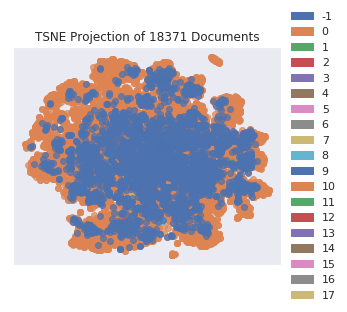

{'min_samples': 6.0, 'eps': 0.8}


'read tfidf_cosine_dist'

Estimated number of clusters_: 15
Estimated number of points: 18371
Estimated number of noise points: 3361
Homogeneity: 0.010
Completeness: 0.035
V-measure: 0.016
Adjusted Rand Index: 0.011
Adjusted Mutual Information: 0.014


'read tfidf_cosine_dist'

Estimated number of clusters_: 15
Estimated number of points: 18371
Estimated number of noise points: 3361


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

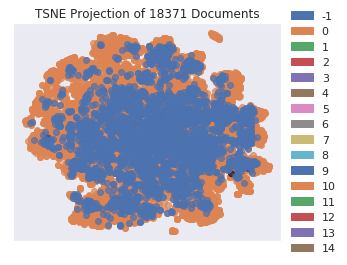

{'min_samples': 7.0, 'eps': 0.8}


'read tfidf_cosine_dist'

Estimated number of clusters_: 17
Estimated number of points: 18371
Estimated number of noise points: 3692
Homogeneity: 0.011
Completeness: 0.035
V-measure: 0.017
Adjusted Rand Index: 0.012
Adjusted Mutual Information: 0.014


'read tfidf_cosine_dist'

Estimated number of clusters_: 17
Estimated number of points: 18371
Estimated number of noise points: 3692


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

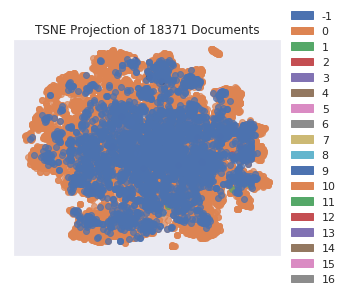

{'min_samples': 8.0, 'eps': 0.8}


'read tfidf_cosine_dist'

Estimated number of clusters_: 12
Estimated number of points: 18371
Estimated number of noise points: 3987
Homogeneity: 0.011
Completeness: 0.034
V-measure: 0.017
Adjusted Rand Index: 0.013
Adjusted Mutual Information: 0.015


'read tfidf_cosine_dist'

Estimated number of clusters_: 12
Estimated number of points: 18371
Estimated number of noise points: 3987


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

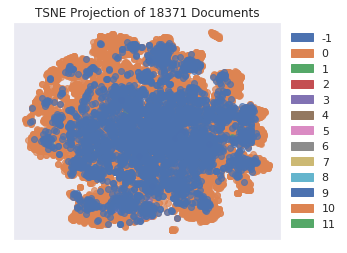

{'min_samples': 9.0, 'eps': 0.8}


'read tfidf_cosine_dist'

Estimated number of clusters_: 11
Estimated number of points: 18371
Estimated number of noise points: 4243
Homogeneity: 0.011
Completeness: 0.034
V-measure: 0.017
Adjusted Rand Index: 0.013
Adjusted Mutual Information: 0.015


'read tfidf_cosine_dist'

Estimated number of clusters_: 11
Estimated number of points: 18371
Estimated number of noise points: 4243


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

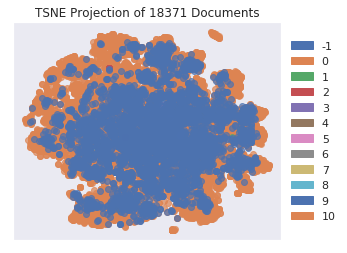

{'min_samples': 10.0, 'eps': 0.8}


'read tfidf_cosine_dist'

Estimated number of clusters_: 6
Estimated number of points: 18371
Estimated number of noise points: 4521
Homogeneity: 0.011
Completeness: 0.032
V-measure: 0.016
Adjusted Rand Index: 0.015
Adjusted Mutual Information: 0.015


'read tfidf_cosine_dist'

Estimated number of clusters_: 6
Estimated number of points: 18371
Estimated number of noise points: 4521


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

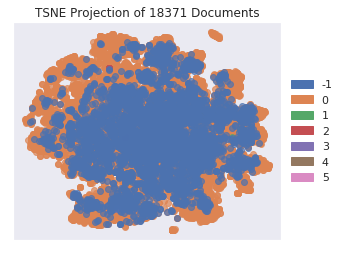

{'min_samples': 3.0, 'eps': 0.8250000000000001}


'read tfidf_cosine_dist'

Estimated number of clusters_: 9
Estimated number of points: 18371
Estimated number of noise points: 1169
Homogeneity: 0.003
Completeness: 0.023
V-measure: 0.006
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.004


'read tfidf_cosine_dist'

Estimated number of clusters_: 9
Estimated number of points: 18371
Estimated number of noise points: 1169


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

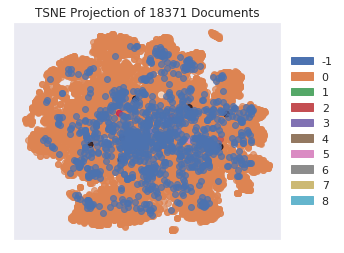

{'min_samples': 2.0, 'eps': 0.8500000000000001}


'read tfidf_cosine_dist'

Estimated number of clusters_: 21
Estimated number of points: 18371
Estimated number of noise points: 418
Homogeneity: 0.003
Completeness: 0.035
V-measure: 0.005
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.002


'read tfidf_cosine_dist'

Estimated number of clusters_: 21
Estimated number of points: 18371
Estimated number of noise points: 418


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

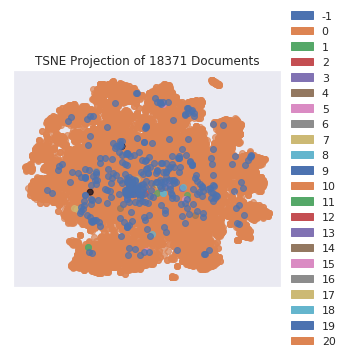

In [55]:
for param in adapter.params_generator():
    adapter.set_params(param)
    print(param)
    adapter.calculate_metrics()
    adapter.clusters_tsne(labels = adapter.get_labels(0), title='tsne_{}'.format(adapter.estimator_name()))